# **Predicting Insurance Benefits**<a id='home'></a>

**Background:** Sure Tomorrow insurance company wants to predict how likely a new customer is to receive an insurance benefit and the number of insurance benefits that new customer is likely to receive. The number of customers receiving insurance benefits is far smaller than the number of customers not receiving insurance benefits, making this an imbalanced classification problem.

**Purpose:**
1. Find customers similar to a given customer.
2. Create a model that maximizes F1 score predicting whether a customer will receive benefits.
3. Create a model that maximizes macro F1 score predicting how many benefits a customer will receive.

**Sections:**  
* [Import Data and Packages](#import)
* [Prepare Data](#prepare)
* [Exploratory Data Analysis](#exploratory)
* [Find Similar Customers (KNN)](#knn)
* [Predict which Customers Recieve Benefits (Binary Classification)](#knn_class)
* [Predict Number of Benefits (Multi-Class Classification)](#knn_regress)
* [Conclusion and Business Application](#conclusion)


## <b>Import Packages and Data</b><a id='import'></a>

In [1]:
# Import Packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

In [2]:
# User-defined GridSearchCV results function
def gscv_results(gscv_object, main_scorer, *add_scores):
    '''Take an sklearn GridSearchCV object and return best model parameters and a 
    pandas dataframe of the main score and additional specified scorers for the best model.
    
    gscv_object: fitted GridSearchCV object with one or multiple scorers.
    main_scorer: scorer passed to gscv_object, or refit score if gscv_object has multiple scorers.
    add_scores: list of additional score names passed to gscv_object.'''
    cv_results = pd.DataFrame(gscv_object.cv_results_).sort_values(by=f'mean_test_{main_scorer}', ascending=False)

    best_params = gscv_object.best_params_
    best_index = gscv_object.best_index_

    # create data frame with best main score
    best_score = gscv_object.best_score_.round(4)
    results = pd.DataFrame(data={f'{main_scorer}':[best_score]})
    
    # for score in additional scores, add column with score
    for score in add_scores:
        results[f'{score}'] = cv_results.loc[best_index, f'mean_test_{score}'].round(4)

    return best_params, results

In [3]:
# User-defined cross_validate results function
def cv_results(cv_object, main_scorer, *add_scores):
    '''Take a sklearn cross_validate object and return a pandas dataframe of 
    the average main score and average of any additional scores across cross 
    validated trials.
    
    cv_object: fitted cross_validate object with one or multiple scorers.
    main_scorer: scorer passed to cross_validate object, or refit score if cross_validate
                 has multiple scorers.
    add_scores: list of additional score names passed to cv_object.'''
     # create data frame with best main score
    main_scorer_avg = cv_object[f'test_{main_scorer}'].mean()
    results = pd.DataFrame(data={f'{main_scorer}': [main_scorer_avg]})
    
    # for score in additional scores, calculate average and add column with score
    for score in add_scores:
        score_avg = cv_object[f'test_{score}'].mean()
        results[f'{score}'] = score_avg
    
    return results

In [4]:
# Read data
try:
    insure = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/insurance_us.csv')
except:
    insure = pd.read_csv('/datasets/insurance_us.csv')

In [5]:
# Print info
print(insure.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              5000 non-null   int64  
 1   Age                 5000 non-null   float64
 2   Salary              5000 non-null   float64
 3   Family members      5000 non-null   int64  
 4   Insurance benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB
None


There are 5000 rows in the dataset and no missing values. All data types are correct.

In [6]:
# Print head
display(insure.head(10))

,Gender,Age,Salary,Family members,Insurance benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
5,1,43.0,41000.0,2,1
6,1,39.0,39700.0,2,0
7,1,25.0,38600.0,4,0
8,1,36.0,49700.0,1,0
9,1,32.0,51700.0,1,0


### Read data conclusions

This analysis has one dataset containing 5 columns and 5000 rows. Columns represent insurance clients' gender, age, salary, number of family members, and insurance benefits. Column names need to be changed to snake case. There are no missing values.

[back to top](#home)

## <b>Prepare Data</b><a id='prepare'></a>

Column names are changed to snake case, dataset is checked for duplicates, and a binary filed claim feature is added.

### Fix columns names

In [7]:
# Change columns to snake case
insure.columns = insure.columns.str.lower().str.replace(' ', '_')

print(insure.columns)

Index(['gender', 'age', 'salary', 'family_members', 'insurance_benefits'], dtype='object')


Columns are converted to snake case.

### Check for Duplicates

In [8]:
# Check for full duplicates
num_duplicates = insure.duplicated().sum()

print(f'The number of fully duplicated rows: {num_duplicates}')

The number of fully duplicated rows: 153


While there are duplicated rows, this is likely due to multiple people sharing the same gender, age, salary, family members, and insurance benefits. These duplicates will be left in the dataset.

### Add additional Features

In [9]:
# Add binary filed claim variable where
# 0 = filed no claims and 1 = filed at least one claime
insure['recieved_benefit'] = np.where(insure['insurance_benefits'] > 0, 1, 0)

display(insure.head())

,gender,age,salary,family_members,insurance_benefits,recieved_benefit
0,1,41.0,49600.0,1,0,0
1,0,46.0,38000.0,1,1,1
2,0,29.0,21000.0,0,0,0
3,0,21.0,41700.0,2,0,0
4,1,28.0,26100.0,0,0,0


### Prepare data conclusions

Variable names are snake case, duplicates have been explored, and a binary filed claim feature is added. The data is ready for analysis.

### <b>Exploratory Data Analysis</b><a id='exploratory'></a>

Variables' individual distributions are explored as well as pairwise plots for the full dataset and colored by number of insurance benefits. 

### Pair plots

/Users/kellyshreeve/anaconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Pairs Plot:


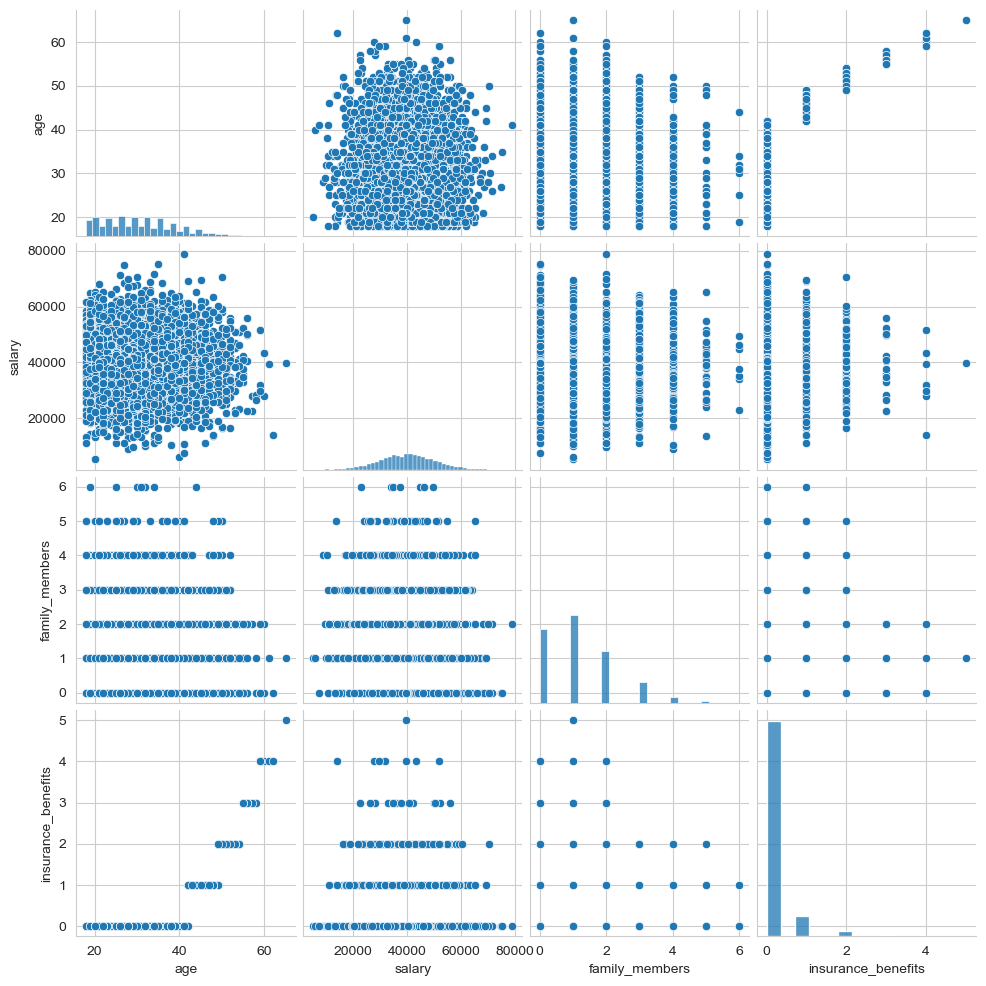

In [10]:
# Pair plot for age, salary, family members, and insurance benefits
sns.set_style('whitegrid')
sns.pairplot(insure.iloc[:, 1:5])

print('Pairs Plot:')
plt.show()

Age, family members, and insurance benefits are highly right skewed variables. Salary appears normally distributed. There is a non-linear relationship betweeen insurance benefits and age and family members. Assumptions of a linear regression appear violated, making this dataset a good candidate for non-parametric models.

/Users/kellyshreeve/anaconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Pairs Plot by Recieved Benefit:


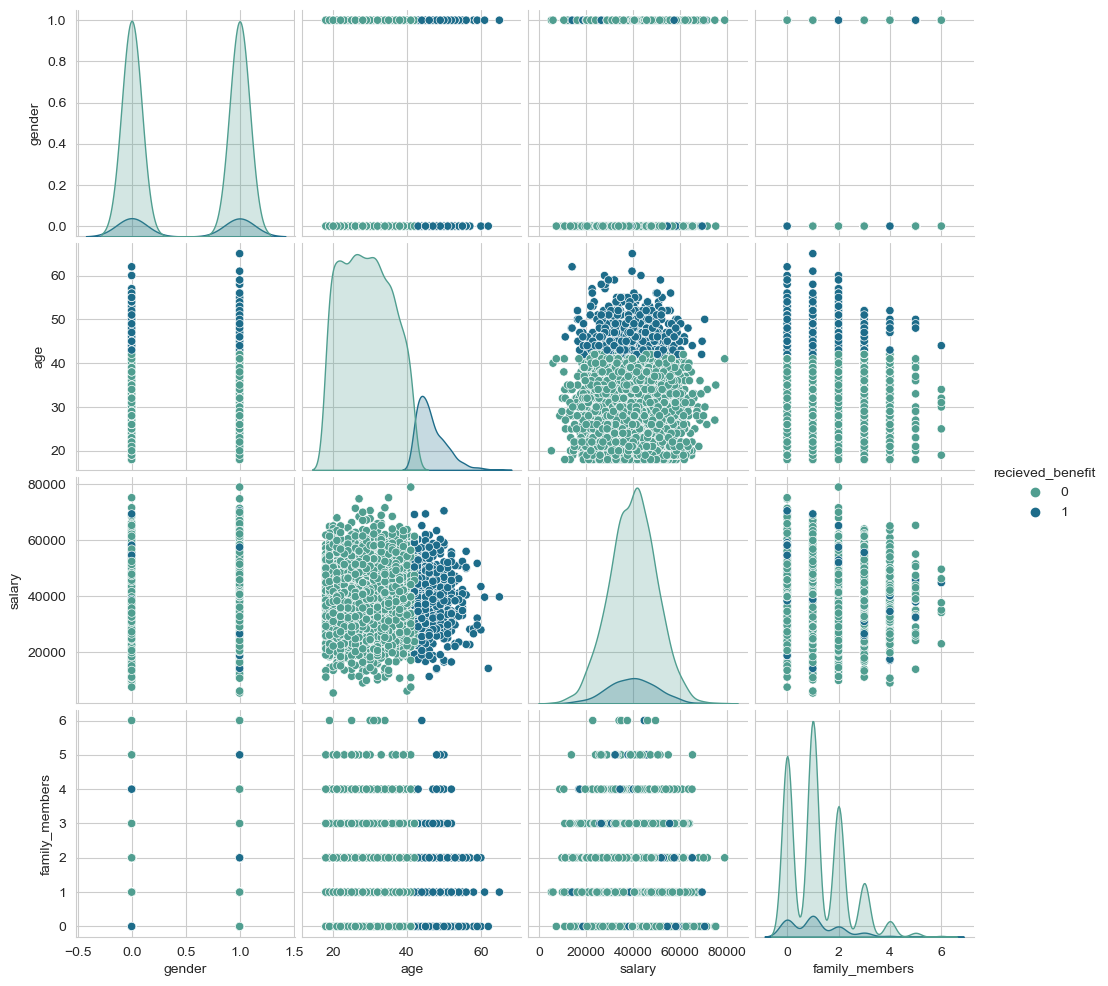

In [11]:
sns.set_style('whitegrid')
sns.pairplot(insure.iloc[:, [0, 1, 2, 3, 5]], hue='recieved_benefit', palette='crest')
sns.color_palette(palette='pastel')

print('Pairs Plot by Recieved Benefit:')
plt.show()

There is strong clustering in recieving benefits or not based on age. People between 18 and 40 have not recieved any benefits and those between 42 and 65 have all recieved benefits. There are no other strong associations or clustering between gender, salary, family members, and recieving insurance benefits.

/Users/kellyshreeve/anaconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Pairs Plot by Number of Benefits:


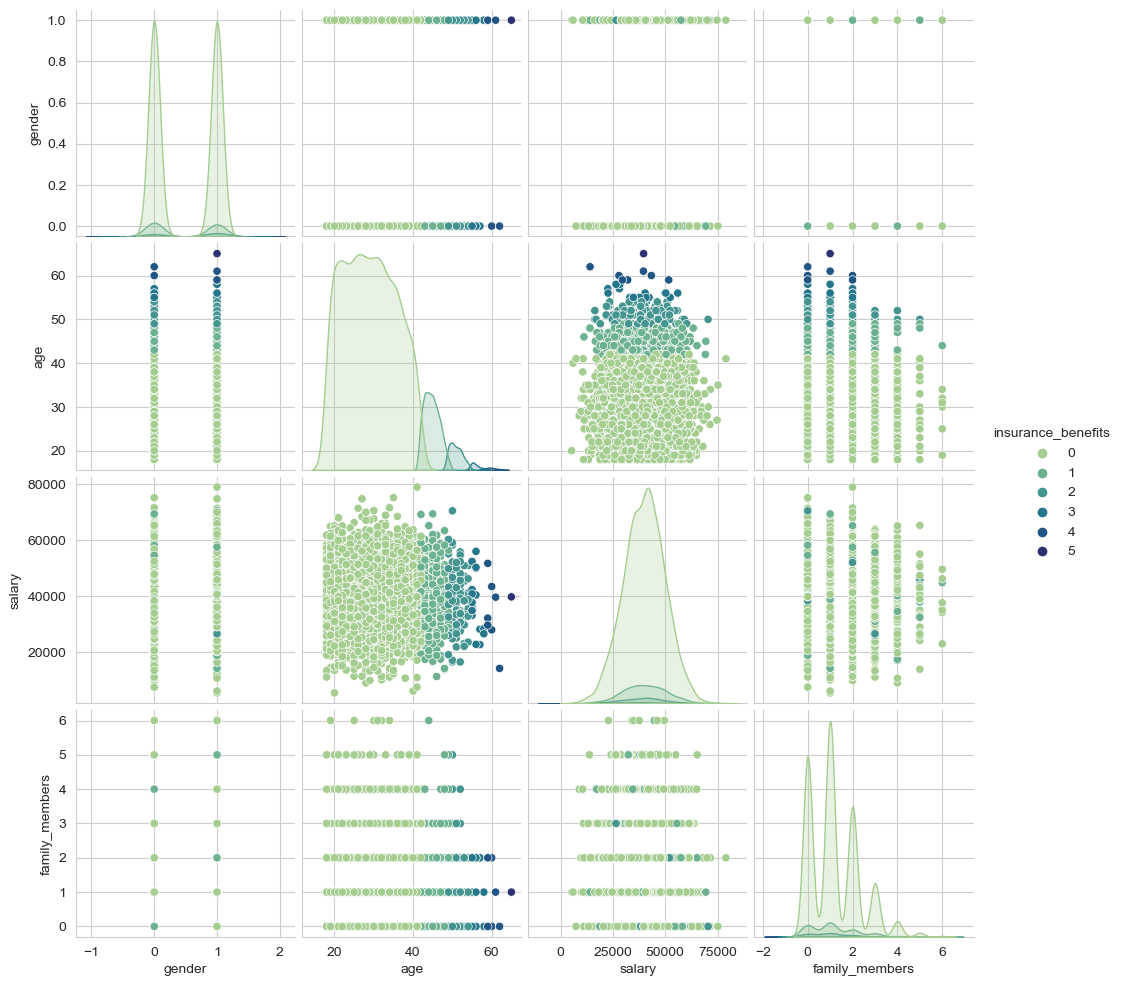

In [12]:
sns.set_style('whitegrid')
sns.pairplot(insure.iloc[:, 0:5], hue='insurance_benefits', palette='crest')

print('Pairs Plot by Number of Benefits:')
plt.show()

The number of benefits someone has recieved is again dependent on age. At older ages, people have all recieved a higher number of benefits. There are no other strong associations or clustering for number of benefits.

### Frequency distributions

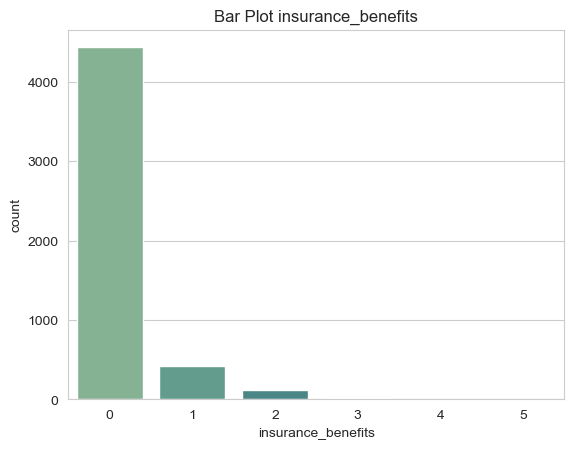

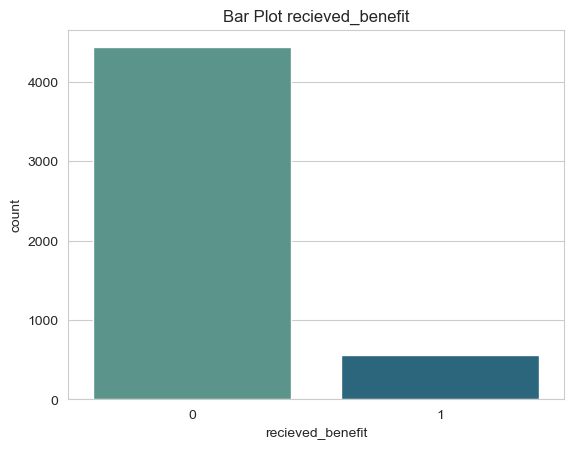

In [13]:
# Bar graphs of dependent variables
columns = ['insurance_benefits', 'recieved_benefit']

for column in columns:
    sns.countplot(x=insure[column], palette='crest').set(title=f'Bar Plot {column}')
    plt.show()

Far more people didn't recieve a benefit than did. There are very few people who recieved 2 or more benefits. There is an imbalance in classes.

In [14]:
# Frequency/Rel Freq/Cum Rel Feq table of gender, family members,
# total insurance benefits, and filed claim
columns = ['gender', 'family_members', 'insurance_benefits', 'recieved_benefit']

for column in columns:
    freq_table = insure[column].value_counts().sort_index().reset_index()

    freq_table['Relative Frequency'] = (insure[column]
                                             .value_counts(normalize=True)
                                             .sort_index()
                                             .values)

    freq_table['Cumulative Frequency'] = (insure[column]
                                               .value_counts(normalize=True)
                                               .sort_index()
                                               .cumsum().values)

    freq_table = freq_table.rename(columns={'index':'Claims Number',
                                            column:'Frequency'})
                                   
    print(f'Frequency Table {column}:')
    display(freq_table)


Frequency Table gender:


,Frequency,count,Relative Frequency,Cumulative Frequency
0,0,2505,0.501,0.501
1,1,2495,0.499,1.000


Frequency Table family_members:


,Frequency,count,Relative Frequency,Cumulative Frequency
0,0,1513,0.3026,0.3026
1,1,1814,0.3628,0.6654
2,2,1071,0.2142,0.8796
3,3,439,0.0878,0.9674
4,4,124,0.0248,0.9922
5,5,32,0.0064,0.9986
6,6,7,0.0014,1.0000


Frequency Table insurance_benefits:


,Frequency,count,Relative Frequency,Cumulative Frequency
0,0,4436,0.8872,0.8872
1,1,423,0.0846,0.9718
2,2,115,0.0230,0.9948
3,3,18,0.0036,0.9984
4,4,7,0.0014,0.9998
5,5,1,0.0002,1.0000


Frequency Table recieved_benefit:


,Frequency,count,Relative Frequency,Cumulative Frequency
0,0,4436,0.8872,0.8872
1,1,564,0.1128,1.0000


There are almost equal numbers of men and women in the dataset. Of customers in this dataset, the most common number of family members is one with 36.38% having one family member, followed by 30.26% having no family members. Only 3.26% of customers have 4 or more family members.  88.72% recieved no insurance benefits, while only 8.46% recieved one benefit, and 2.82% recieved two or more benefits. Similarly, 88.72% of customers recieved no benefit vs 11.28% recieved at least one benefit. This is an imbalanced classification problem.

Only one person recieved 5 insurance benefits. This category will be combined with 4 insurance benefits for better model predictions.

### Combine classes

In [15]:
# Combine 5 benefits with 4 benefits
insure['insurance_benefits'] = insure['insurance_benefits'].replace(5, 4)

freq_table = insure['insurance_benefits'].value_counts().sort_index().reset_index()

freq_table['Relative Frequency'] = (insure['insurance_benefits']
                                        .value_counts(normalize=True)
                                        .sort_index()
                                        .values)

freq_table['Cumulative Frequency'] = (insure['insurance_benefits']
                                               .value_counts(normalize=True)
                                               .sort_index()
                                               .cumsum().values)

freq_table = freq_table.rename(columns={'index':'Claims Number',
                                            'insurance_benefits':'Frequency'})
                                   
print(f'Updated Frequency Table insurance_benefits:')
display(freq_table)

Updated Frequency Table insurance_benefits:


,Frequency,count,Relative Frequency,Cumulative Frequency
0,0,4436,0.8872,0.8872
1,1,423,0.0846,0.9718
2,2,115,0.0230,0.9948
3,3,18,0.0036,0.9984
4,4,8,0.0016,1.0000


The category with 5 insurance benefits has been combined with 4 insurance benefits.

### Exploratory Data Analysis Conclusion

Multiple feature variables have high skews and the target variables have uneven class numbers. The large violations in parametric assumptions make this dataset a good candidate for non-parametric models with imbalanced classificaiton techniques. The analysis will proceed with k nearest neighbors classification, logistic regression, and random forest classification models with class balancing methods.

[back to top](#home)

## <b>Find Similar Customers</b><a id='knn'></a>

Use K Nearest Neighbors to find customers similar to a given customer.

In [33]:
# Initiate Nearest Neighbors Class to find closest 5 customers
knn = NearestNeighbors(n_neighbors=5).fit(insure)

# Test model on example characteristics
distance, index = knn.kneighbors([[0, 29, 60000, 1, 0, 0]])

print(index)
print(distance)

[[3520 1555 1742 1418 2239]]
[[  7.14142843 100.0099995  100.01499888 100.01499888 100.019998  ]]


/Users/kellyshreeve/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


The most similar customers are at indexes 3520, 1555, 1742, 1418, and 2239

## <b>Predict which Customers Recieve Benefits</b><a id='knn_class'></a>

<b>Purpose:</b> Machine learning binary classification models are tuned and cross-validated to find the model that best predicts which customers recieve insurance benefits. This is an imbalanced binary classification problem.

<b>Techniques:</b> Pipelines, GridSearchCV, and imbalanced classification techniques are utilized to fit and tune k-nearest neighbor classifier and logistic regression models with the purpose of maximizing F1 score. Imbalanced classes are balanced using SMOTE, SMOTEENN, and weighting, and the logistic regression threshold is tuned.   

<b>Sections:</b>  
[KNN Models](#knn_class)  
[Logistic Regression Models](#log_reg)  
[Training Results](#results_class)  
[Test Results](#test_class)  
[Classification Conclusions](#conclusion_class)

### Prepare training and test sets

In [20]:
# Define features and target
features = insure.drop(['insurance_benefits', 'recieved_benefit'], axis=1)
target_class = insure['recieved_benefit']

print('Features:')
display(features.head())
print()

print('Target:')
display(target_class.head().to_frame())

Features:


,gender,age,salary,family_members
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0
3,0,21.0,41700.0,2
4,1,28.0,26100.0,0



Target:


,recieved_benefit
0,0
1,1
2,0
3,0
4,0


In [21]:
# Split data into train and test
features_train, features_test, target_train_class, target_test_class = train_test_split(features, target_class,
                                                                            test_size=0.25, random_state=123)

print(f'Features Train: {features_train.shape}')
print(f'Target Train: {target_train_class.shape}')

print(f'Features Test: {features_test.shape}')
print(f'Target Test: {target_test_class.shape}')

Features Train: (3750, 4)
Target Train: (3750,)
Features Test: (1250, 4)
Target Test: (1250,)


### KNN binary classification models<a id='knn_class'></a>

In [34]:
# define scaler for numeric columns
preprocessor = ColumnTransformer(
    transformers=[('scaler', StandardScaler(), slice(1, 4))],
    remainder='passthrough'
)

# define scores for GridSearchCV
scores = {'accuracy': 'accuracy', 
          'precision': 'precision', 
          'recall': 'recall', 
          'f1': 'f1', 
          'roc_auc': 'roc_auc'}

In [24]:
# Scale and tune kNN classifier with imbalanced classes as baseline

# pipeline to scale and fit knn
pipe = Pipeline(steps=[('scale', preprocessor), ('knn', KNeighborsClassifier(n_jobs=-1))])

grid = {
    'knn__n_neighbors':np.arange(1, 25, 2),
    'knn__weights':['uniform', 'distance'],
    'knn__metric':['euclidean', 'cityblock', 'minkowski'],
    'knn__algorithm':['ball_tree','kd_tree', 'brute']
}

# scale, tune, and fit knn with k = 3 folds and refit on F1 score
knn_class_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scores, cv=3, refit='f1')
knn_class_gscv.fit(features_train, target_train_class)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scale',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         slice(1, 4, None))])),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-1))]),
             param_grid={'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'knn__metric': ['euclidean', 'cityblock', 'minkowski'],
                         'knn__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23]),
                         'knn__weights': ['uniform', 'distance']},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [385]:
# User-defined function to extract training results
imb_knn_best_params, imbalanced_knn_results = gscv_results(knn_class_gscv, 'f1', 'roc_auc', 'accuracy', 'precision', 'recall')

print('Imbalanced KNN Best Parameters:')
print(imb_knn_best_params)
print()

print('Imbalanced KNN CV Results:')
display(imbalanced_knn_results)

Imbalanced KNN Best Parameters:
{'knn__algorithm': 'kd_tree', 'knn__metric': 'cityblock', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}

Imbalanced KNN CV Results:


,f1,roc_auc,accuracy,precision,recall
0,0.9279,0.9468,0.9843,0.9595,0.8983


In [17]:
# Upsample with SMOTE to improve KNN score
upsample = SMOTE(random_state=123)

# Add upsample to pipe
pipe_smote = Pipeline([('smt', upsample), ('scale', preprocessor), ('knn', KNeighborsClassifier(n_jobs=-1))])

grid = {
    'knn__n_neighbors': np.arange(1, 26, 2),
    'knn__weights':['uniform', 'distance'],
    'knn__metric':['euclidean', 'cityblock', 'minkowski'],
    'knn__algorithm':['ball_tree','kd_tree', 'brute'],
    'smt__k_neighbors': np.arange(1, 22, 2)
}

# Re-tune with k = 3 folds and refit on F1 score
knn_class_smt_gscv = GridSearchCV(pipe_smote, param_grid=grid, scoring=scores, cv=3, refit='f1')
knn_class_smt_gscv.fit(features_train, target_train_class)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('smt', SMOTE(random_state=123)),
                                       ('scale',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         slice(1, 4, None))])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'knn__metric': ['euclidean', 'cityblock', 'minkowski'],
                         'knn__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25]),
                         'knn__weights': ['uniform', 'distance'],
                         'smt__k_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21])},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [384]:
# Extract training results
smote_knn_best, smote_knn_results = gscv_results(knn_class_smt_gscv, 'f1', 'roc_auc', 'accuracy', 'precision', 'recall')

print('SMOTE KNN Best Parameters:')
print(smote_knn_best)
print()
print('SMOTE KNN CV Results:')
display(smote_knn_results)

SMOTE KNN Best Parameters:
{'knn__algorithm': 'ball_tree', 'knn__metric': 'cityblock', 'knn__n_neighbors': 7, 'knn__weights': 'distance', 'smt__k_neighbors': 11}

SMOTE KNN CV Results:


,f1,roc_auc,accuracy,precision,recall
0,0.9409,0.998,0.9861,0.9059,0.9787


In [18]:
# Up and down sample with SMOTEENN and re-fit KNN
upsample_smtn = SMOTEENN(random_state=123)

# Add SMOTEENN to pipe
pipe_smtn = Pipeline([('smtn', upsample_smtn), ('scale', preprocessor), ('knn', KNeighborsClassifier(n_jobs=-1))])

grid = {
    'knn__n_neighbors': np.arange(1, 21, 2),
    'knn__weights':['uniform', 'distance'],
    'knn__metric':['euclidean', 'cityblock', 'minkowski'],
    'knn__algorithm':['ball_tree','kd_tree', 'brute'],
    'smtn__smote': [SMOTE(k_neighbors=1), 
                    SMOTE(k_neighbors=5), 
                    SMOTE(k_neighbors=10)],
    'smtn__enn': [EditedNearestNeighbours(n_neighbors=1), 
                  EditedNearestNeighbours(n_neighbors=3),
                  EditedNearestNeighbours(n_neighbors=5)]
}

# Re-tune with k = 3 folds and refit on F1 score
knn_class_smtn_gscv = GridSearchCV(pipe_smtn, param_grid=grid, scoring=scores, cv=3, refit='f1')
knn_class_smtn_gscv.fit(features_train, target_train_class)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('smtn', SMOTEENN(random_state=123)),
                                       ('scale',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         slice(1, 4, None))])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'knn__metric': ['euclidean', 'cityblock', 'minkowski'],
                         'knn__n_neig...15, 17, 19]),
                         'knn__weights': ['uniform', 'distance'],
                         'smtn__enn': [EditedNearestNeighbours(n_neighbors=1),
                                       EditedNearestNeighbours(),
                                       EditedNearestNeighbours(n_neighbors=5)],
                         'smtn__smote': [SMOTE(k_neighbors=1), SMOTE(),
                                         SMOTE(k_neighbors=10)]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [383]:
# Extract results
smtn_knn_best, smtn_knn_results = gscv_results(knn_class_smtn_gscv, 'f1', 'roc_auc', 'accuracy', 'precision', 'recall')

print('SMOTEENN KNN Best Parameters:')
print(smtn_knn_best)
print()
print('SMOTEENN KNN CV Results:')
display(smtn_knn_results)

SMOTEENN KNN Best Parameters:
{'knn__algorithm': 'kd_tree', 'knn__metric': 'cityblock', 'knn__n_neighbors': 1, 'knn__weights': 'distance', 'smtn__enn': EditedNearestNeighbours(n_neighbors=1), 'smtn__smote': SMOTE()}

SMOTEENN KNN CV Results:


,f1,roc_auc,accuracy,precision,recall
0,0.9365,0.9611,0.9859,0.9444,0.9291


The best KNN classifier is fit on the SMOTE upsampled data and acheived and F1 score of 0.9409.

### Logistic regression binary classification<a id='log_reg'></a>

In [24]:
# Pipeline to scale, fit, and cross validate logistic regression with 
# imbalanced classes as a baseline
model = LogisticRegression(solver='liblinear')

pipe = Pipeline([('scale', preprocessor), ('model', model)])

# Cross-validate baseline model with k = 3 folds
logreg_cv = cross_validate(pipe, features_train, target_train_class,
                               scoring=scores, cv=3)

In [25]:
# Extract model results
logreg_results = cv_results(logreg_cv, 'f1', 'roc_auc', 'accuracy', 'precision', 'recall')

print('Imbalanced Logistic Regression CV Results:')
display(logreg_results.round(4))

Imbalanced Logistic Regression CV Results:


,f1,roc_auc,accuracy,precision,recall
0,0.9745,0.9999,0.9944,1.0,0.9504


In [26]:
# Pipeline to scale, fit, and cross validate logistic regression with 
# class weighting
model = LogisticRegression(solver='liblinear', class_weight='balanced')

pipe = Pipeline([('scale', preprocessor), ('model', model)])

scores = {'accuracy': 'accuracy', 'precision': 'precision', 
          'recall': 'recall', 'f1': 'f1', 'roc_auc': 'roc_auc'}

# Cross-validate model with k = 3 folds
logreg_wtd_cv = cross_validate(pipe, features_train, target_train_class,
                               scoring=scores, cv=3)

In [27]:
# Extract results
logreg_wtd_results = cv_results(logreg_wtd_cv, 'f1', 'roc_auc', 'accuracy', 'precision', 'recall')

print('Weighted Classes Logistic Regression CV Results:')
display(logreg_wtd_results)

Weighted Classes Logistic Regression CV Results:


,f1,roc_auc,accuracy,precision,recall
0,0.869927,0.999981,0.966133,0.770337,1.0


In [292]:
# Logistic regression with SMOTE upsampled data
model = LogisticRegression(solver='liblinear')
upsample = SMOTE(random_state=123)

pipe = Pipeline([('smt', upsample), ('scale', preprocessor), ('model', model)])

grid = {
    'smt__k_neighbors': np.arange(1, 26, 1)
}

# Tune SMOTE and cross-validate logistic regression
logreg_smt_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scores, 
                                   cv=3, refit='f1')
logreg_smt_gscv.fit(features_train, target_train_class)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('smt', SMOTE(random_state=123)),
                                       ('scale',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         slice(1, 4, None))])),
                                       ('model',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'smt__k_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25])},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [380]:
# Extract results
logreg_smt_best, logreg_smt_results = gscv_results(logreg_smt_gscv, 'f1', 'roc_auc', 'accuracy', 'precision', 'recall')

print('SMOTE Logistic Regression Best Parameters:')
print(logreg_smt_best)
print()
print('SMOTE Logistic Regression CV Results:')
display(logreg_smt_results)

SMOTE Logistic Regression Best Parameters:
{'smt__k_neighbors': 19}

SMOTE Logistic Regression CV Results:


,f1,roc_auc,accuracy,precision,recall
0,0.9248,0.9997,0.9816,0.8605,1.0


In [290]:
#Logistic regression with SMOTEENN
model = LogisticRegression(solver='liblinear')
upsample = SMOTEENN(random_state=123)

pipe = Pipeline([('smtn', upsample), ('scale', preprocessor), ('model', model)])

grid = {
    'smtn__smote': [SMOTE(k_neighbors=1), 
                    SMOTE(k_neighbors=5), 
                    SMOTE(k_neighbors=10),
                    SMOTE(k_neighbors=15),
                    SMOTE(k_neighbors=20)],
    'smtn__enn': [EditedNearestNeighbours(n_neighbors=1), 
                  EditedNearestNeighbours(n_neighbors=3),
                  EditedNearestNeighbours(n_neighbors=5),
                  EditedNearestNeighbours(n_neighbors=10)]
}

logreg_smtn_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scores, 
                                   cv=3, refit='f1')
logreg_smtn_gscv.fit(features_train, target_train_class)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('smtn', SMOTEENN(random_state=123)),
                                       ('scale',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         slice(1, 4, None))])),
                                       ('model',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'smtn__enn': [EditedNearestNeighbours(n_neighbors=1),
                                       EditedNearestNeighbours(),
                                       EditedNearestNeighbours(n_neighbors=5),
                                       EditedNearestNeighbours(n_neighbors=10)],
                         'smtn__smote': [SMOTE(k_neighbors=1), SMOTE(),
                                         SMOTE(k_neighbors=10),
                                         SMOTE(k_neighbors=15),
                                         SMOTE(k_neighbors=20)]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [379]:
# Extract results
logreg_smtn_best, logreg_smtn_results = gscv_results(logreg_smtn_gscv, 'f1', 'roc_auc', 'accuracy', 'precision', 'recall')

print('SMOTEENN Logistic Regression Best Parameters:')
print(logreg_smtn_best)
print()
print('SMOTEEN Logistic Regression CV Results:')
display(logreg_smtn_results)

SMOTEENN Logistic Regression Best Parameters:
{'smtn__enn': EditedNearestNeighbours(), 'smtn__smote': SMOTE(k_neighbors=20)}

SMOTEEN Logistic Regression CV Results:


,f1,roc_auc,accuracy,precision,recall
0,0.9571,0.9995,0.9899,0.92,0.9976


In [29]:
# Logistic regression threshold optimatiation

# split training set into train and validate for optimization
features_train_opt, features_valid_opt, target_train_opt, target_valid_opt = train_test_split(
    features_train, target_train_class, test_size=0.25, random_state=123)

# scale training data and fit model
logreg = LogisticRegression(random_state=123)

pipe_logreg = Pipeline([('scale', preprocessor), ('model', logreg)])

pipe_logreg.fit(features_train_opt, target_train_opt)

# extract predicted probabilities
pred_prob = pipe_logreg.predict_proba(features_valid_opt)
pred_prob = pred_prob[:, 1]

# Threshold tuning to maximize f1 score
thresholds = np.arange(0, 1.1, 0.01)
f1_scores = np.zeros(len(thresholds))

for index, elem in enumerate(thresholds):
    predictions = np.where(pred_prob > elem, 1, 0)
    f1_scores[index] = f1_score(target_valid_opt, predictions)

# Extract index and optimal threshold of largest F1 score
index = np.argmax(f1_scores)
threshold_opt = thresholds[index]
f1_score_opt = f1_scores[index]

print(f'Optimal Threshold: {threshold_opt}')
print(f'Optimal F1 Score: {f1_score_opt}')

Optimal Threshold: 0.43
Optimal F1 Score: 1.0


In [20]:
# Score model based on optimal threshold
preds_opt = np.where(pred_prob > threshold_opt, 1, 0)

logreg_thres_results = pd.DataFrame(data={'f1':[f1_score(target_valid_opt, preds_opt)],
                                          'roc_auc':[roc_auc_score(target_valid_opt, preds_opt)],
                                          'accuracy':[accuracy_score(target_valid_opt, preds_opt)],
                                          'precision':[precision_score(target_valid_opt, preds_opt)],
                                          'recall':[recall_score(target_valid_opt, preds_opt)]})

print('Optimized Threshold Logistic Regression Results:')
display(logreg_thres_results)

Optimized Threshold Logistic Regression Results:


,f1,roc_auc,accuracy,precision,recall
0,1.0,1.0,1.0,1.0,1.0


The best logistic regression model was threshold optimized to 0.43 and acheived an F1 score of 1.0 on the validation set.

### Classification Training Results<a id='results_class'></a>

In [389]:
# Display results of classifier analysis
results_full = pd.concat([imbalanced_knn_results, smote_knn_results,
                smtn_knn_results, logreg_results, logreg_wtd_results, 
                logreg_smt_results, logreg_smtn_results, logreg_thres_results])

results_full.index = ['Imbalanced KNN', 'SMOTE KNN',
                   'SMOTEENN KNN', 'Imbalanced Log Reg',
                   'Weighted Log Reg', 'SMOTE Log Reg',
                   'SMOTEENN Log Reg', 'Threshold Opt Log Reg']

print('Results of Machine Learning Classifier Analysis:')
display(results_full.sort_values(by='f1', ascending=False).round(4))

Results of Machine Learning Classifier Analysis:


,f1,roc_auc,accuracy,precision,recall
Threshold Opt Log Reg,1.0000,1.0000,1.0000,1.0000,1.0000
Imbalanced Log Reg,0.9745,0.9999,0.9944,1.0000,0.9504
SMOTEENN Log Reg,0.9571,0.9995,0.9899,0.9200,0.9976
SMOTE KNN,0.9409,0.9980,0.9861,0.9059,0.9787
SMOTEENN KNN,0.9365,0.9611,0.9859,0.9444,0.9291
Imbalanced KNN,0.9279,0.9468,0.9843,0.9595,0.8983
SMOTE Log Reg,0.9248,0.9997,0.9816,0.8605,1.0000
Weighted Log Reg,0.8699,1.0000,0.9661,0.7703,1.0000


The best model was threshold optimized logisitic regression, achieving an F1, ROC AUC, accuracy, precision, and recall score of 1.0. This is followed by the imbalanced logistic regression and logistic regression with SMOTEENN class balancing. All of the KNN models did similarly, with F1 scores all between 0.93 and 0.94. Weighted logistic regression, while achieving perfect recall, had the lowest precision and F1 scores.

### Classification test results <a id='class_test'></a>

In [32]:
# Test logistic regression with threshold = 0.43 on test set
threshold_opt = 0.43

pred_proba_test = pipe_logreg.predict_proba(features_test)[:, 1]

pred_test = np.where(pred_proba_test > threshold_opt, 1, 0)

logreg_test_results = pd.DataFrame(data={'f1':[f1_score(target_test_class, pred_test)],
                                          'roc_auc':[roc_auc_score(target_test_class, pred_test)],
                                          'accuracy':[accuracy_score(target_test_class, pred_test)],
                                          'precision':[precision_score(target_test_class, pred_test)],
                                          'recall':[recall_score(target_test_class, pred_test)]})

print('Logistic Regression Threshold = 0.43 Test:')
display(logreg_test_results)
print()

Logistic Regression Threshold = 0.43 Test:


,f1,roc_auc,accuracy,precision,recall
0,1.0,1.0,1.0,1.0,1.0


In [35]:
# Print Classification Report
print('Logistic Regression Threshold = 0.43 Test Classification Report:')
print()
print(classification_report(target_test_class, pred_test))

Logistic Regression Threshold = 0.43 Test Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1109
           1       1.00      1.00      1.00       141

    accuracy                           1.00      1250
   macro avg       1.00      1.00      1.00      1250
weighted avg       1.00      1.00      1.00      1250



The logistic regression with threshold = 0.43 that was scaled and fit on the training set was able to achieve an f1, roc_auc, accuracy, precision, and recall score of 1.0 on the test set. This is the same score as on the training set and represents a model that can make perfect predictions both on training data and on new data it has not seen.

### Classification Conclusions<a id='conclusion_class'></a>

K nearest neighbors and logistic regression models were fit and tuned with class balancing techniques. The best classifier was the logistic regression with a threshold of 0.43. This model was able to achieve scores of 1.0 across the board for F1, roc_auc, accuracy, precision, and recall on the training set and was able to repeat those scores again on the test set. This model predicts both those that did and those that did not use insurance benefits with 100% accuracy. It is a perfect predictor.

[back to top](#home)

## <b>Predict Number of Benefits (Multi-Class Classification)</b><a id='knn_regress'></a>

<b>Purpose:</b> Machine learning multi-class classification models are tuned and cross-validated to find the model that best predicts the number of insurance benefits a customer will receive. This is an imbalanced classification problem.

<b>Techniques:</b> Pipelines, GridSearchCV, and imbalanced classification techniques are utilized to fit and tune k-nearest neighbor classifier and random forest models with the purpose of maximizing F1 score macro. Imbalanced classes are balanced using SMOTE, SMOTEENN, and weighting.  

<b>Sections:</b>  
[KNN Models](#knn_mult)  
[Random Forest Models](#rf_mult)  
[Training Results](#results_mult)  
[Test Reults](#test_mult)  
[Multi Class Conclusions](#conclude_mult)  

### Prepare training and test sets 

In [23]:
# Specify new target
target_mult = insure['insurance_benefits']

print('Features:')
display(features.head())
print()
print('Target:')
display(target_mult.head().to_frame())

Features:


,gender,age,salary,family_members
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0
3,0,21.0,41700.0,2
4,1,28.0,26100.0,0



Target:


,insurance_benefits
0,0
1,1
2,0
3,0
4,0


In [24]:
# Split data into training and test
feat_train_mult, feat_test_mult, targ_train_mult, targ_test_mult = train_test_split(
    features, target_mult, test_size=0.25, random_state=123)

print(f'Features Train: {feat_train_mult.shape}')
print(f'Target Train: {targ_train_mult.shape}')

print(f'Features Test: {feat_test_mult.shape}')
print(f'Target Test: {targ_test_mult.shape}')

Features Train: (3750, 4)
Target Train: (3750,)
Features Test: (1250, 4)
Target Test: (1250,)


### KNN multi classification models<a id='knn_mult'></a>

In [30]:
# Define scorers for multi classification

# Macro average to penalize inaccurate predictions of minority classes
precision_defined = make_scorer(precision_score, average='macro', zero_division=np.nan)

scores = {'accuracy': 'accuracy', 
          'precision_macro': precision_defined, 
          'recall_macro': 'recall_macro', 
          'f1_macro':'f1_macro', 
          'roc_auc_weighted': 'roc_auc_ovr_weighted'}

In [31]:
# Fit and tune imbalanced KNN model as baseline
model = KNeighborsClassifier(n_jobs=-1)

pipe = Pipeline(steps=[('scale', preprocessor), ('knn', model)])

grid = {
    'knn__n_neighbors':np.arange(1, 26, 2),
    'knn__weights':['uniform', 'distance'],
    'knn__algorithm':['ball_tree', 'kd_tree', 'brute'],
    'knn__metric':['euclidean', 'cityblock', 'minkowski']
}

knn_mult_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scores, cv=3, refit='f1_macro')
knn_mult_gscv.fit(feat_train_mult, targ_train_mult)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scale',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         slice(1, 4, None))])),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-1))]),
             param_grid={'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'knn__metric': ['euclidean', 'cityblock', 'minkowski'],
                         'knn__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25]),
                         'knn__weights': ['uniform', 'distance']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro',
                      'precision_macro': make_scorer(precision_score, average=macro, zero_division=nan),
                      'recall_macro': 'recall_macro',
                      'roc_auc_weighted': 'roc_auc_ovr_weighted'})

In [32]:
# Print imbalanced knn training results
knn_mult_best, knn_mult_gscv_result = gscv_results(knn_mult_gscv, 'f1_macro', 'roc_auc_weighted', 
                                                   'accuracy', 'precision_macro', 'recall_macro')

print('Multi-Class Imbalanced KNN Best Model:')
print(knn_mult_best)
print()
print('Multi-Class Imbalanced KNN CV Results:')
display(knn_mult_gscv_result)

Multi-Class Imbalanced KNN Best Model:
{'knn__algorithm': 'ball_tree', 'knn__metric': 'cityblock', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}

Multi-Class Imbalanced KNN CV Results:


,f1_macro,roc_auc_weighted,accuracy,precision_macro,recall_macro
0,0.6181,0.9833,0.9701,0.7482,0.5991


In [33]:
# SMOTE Upsamle Multi Class KNN
upsample = SMOTE(sampling_strategy='not majority', random_state=123)
model = KNeighborsClassifier(n_jobs=-1)

pipe = Pipeline([('smt', upsample), ('scale', preprocessor), ('knn', model)])

grid = {
    'knn__n_neighbors':np.arange(1, 26, 2),
    'knn__weights':['uniform', 'distance'],
    'knn__algorithm':['ball_tree', 'kd_tree', 'brute'],
    'knn__metric':['euclidean', 'cityblock', 'minkowski'],
    'smt__k_neighbors':np.arange(1, 3)
}

knn_mult_smt_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scores, cv=3, refit='f1_macro')
knn_mult_smt_gscv.fit(feat_train_mult, targ_train_mult)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('smt',
                                        SMOTE(random_state=123,
                                              sampling_strategy='not '
                                                                'majority')),
                                       ('scale',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         slice(1, 4, None))])),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-1))]),
             param_grid={'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'knn__metric': ['euclidean...
                         'knn__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25]),
                         'knn__weights': ['uniform', 'distance'],
                         'smt__k_neighbors': array([1, 2])},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro',
                      'precision_macro': make_scorer(precision_score, average=macro, zero_division=nan),
                      'recall_macro': 'recall_macro',
                      'roc_auc_weighted': 'roc_auc_ovr_weighted'})

In [34]:
# Print SMOTE upsampled results
knn_mult_smt_best, knn_mult_smt_gscv_result = gscv_results(knn_mult_smt_gscv, 'f1_macro', 'roc_auc_weighted', 
                                                   'accuracy', 'precision_macro', 'recall_macro')

print('Multi-Class SMOTE Upsampled KNN Best Model:')
print(knn_mult_smt_best)
print()
print('Multi-Class SMOTE Upsampled KNN CV Results:')
display(knn_mult_smt_gscv_result)

Multi-Class SMOTE Upsampled KNN Best Model:
{'knn__algorithm': 'ball_tree', 'knn__metric': 'cityblock', 'knn__n_neighbors': 5, 'knn__weights': 'distance', 'smt__k_neighbors': 2}

Multi-Class SMOTE Upsampled KNN CV Results:


,f1_macro,roc_auc_weighted,accuracy,precision_macro,recall_macro
0,0.7112,0.9868,0.9672,0.7135,0.7148


In [35]:
# SMOTEENN Upsamle/Downsample Multi Class KNN
balance = SMOTEENN(random_state=123)
model = KNeighborsClassifier(n_jobs=-1)

pipe = Pipeline([('smtn', balance), ('scale', preprocessor), ('knn', model)])

grid = {
    'knn__n_neighbors':np.arange(1, 16, 2),
    'knn__weights':['uniform', 'distance'],
    'knn__algorithm':['ball_tree', 'kd_tree', 'brute'],
    'knn__metric':['euclidean', 'cityblock', 'minkowski'],
    'smtn__smote':[SMOTE(k_neighbors=1), 
                    SMOTE(k_neighbors=2)],
    'smtn__enn': [EditedNearestNeighbours(n_neighbors=1), 
                  EditedNearestNeighbours(n_neighbors=2)]
}

knn_mult_smtn_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scores, cv=3, refit='f1_macro')
knn_mult_smtn_gscv.fit(feat_train_mult, targ_train_mult)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('smtn', SMOTEENN(random_state=123)),
                                       ('scale',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         slice(1, 4, None))])),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-1))]),
             param_grid={'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'knn__metric': ['euclidean', 'cityblock', 'minkowski'],
                         'kn...
                         'smtn__enn': [EditedNearestNeighbours(n_neighbors=1),
                                       EditedNearestNeighbours(n_neighbors=2)],
                         'smtn__smote': [SMOTE(k_neighbors=1),
                                         SMOTE(k_neighbors=2)]},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro',
                      'precision_macro': make_scorer(precision_score, average=macro, zero_division=nan),
                      'recall_macro': 'recall_macro',
                      'roc_auc_weighted': 'roc_auc_ovr_weighted'})

In [36]:
# SMOTEENN KNN upsampled results
knn_mult_smtn_best, knn_mult_smtn_gscv_result = gscv_results(knn_mult_smtn_gscv, 'f1_macro', 'roc_auc_weighted', 
                                                   'accuracy', 'precision_macro', 'recall_macro')

print('Multi-Class SMOTEENN Upsampled KNN Best Model:')
print(knn_mult_smtn_best)
print()
print('Multi-Class SMOTEENN Upsampled KNN CV Results:')
display(knn_mult_smtn_gscv_result)

Multi-Class SMOTEENN Upsampled KNN Best Model:
{'knn__algorithm': 'kd_tree', 'knn__metric': 'cityblock', 'knn__n_neighbors': 9, 'knn__weights': 'distance', 'smtn__enn': EditedNearestNeighbours(n_neighbors=2), 'smtn__smote': SMOTE(k_neighbors=2)}

Multi-Class SMOTEENN Upsampled KNN CV Results:


,f1_macro,roc_auc_weighted,accuracy,precision_macro,recall_macro
0,0.7094,0.9871,0.9629,0.7275,0.7019


### Random forest classification models<a id='rf_mult'></a>

In [37]:
# Imbalanced random forest
model = RandomForestClassifier(random_state=123)

pipe = Pipeline([('scale', preprocessor), ('rf', model)])

grid = {
    'rf__n_estimators':np.arange(1, 160, 20),
    'rf__criterion':['gini', 'entropy', 'log_loss'],
    'rf__max_depth':np.arange(1, 15, 2)
}

rf_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scores, cv=3, refit='f1_macro')
rf_gscv.fit(feat_train_mult, targ_train_mult)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scale',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         slice(1, 4, None))])),
                                       ('rf',
                                        RandomForestClassifier(random_state=123))]),
             param_grid={'rf__criterion': ['gini', 'entropy', 'log_loss'],
                         'rf__max_depth': array([ 1,  3,  5,  7,  9, 11, 13]),
                         'rf__n_estimators': array([  1,  21,  41,  61,  81, 101, 121, 141])},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro',
                      'precision_macro': make_scorer(precision_score, average=macro, zero_division=nan),
                      'recall_macro': 'recall_macro',
                      'roc_auc_weighted': 'roc_auc_ovr_weighted'})

In [38]:
# Imbalanced random forest results
rf_best, rf_gscv_result = gscv_results(rf_gscv, 'f1_macro', 'roc_auc_weighted', 'accuracy', 
                                       'precision_macro', 'recall_macro')

print('Multi-Class Imbalanced Random Forest Best Model:')
print(rf_best)
print()
print('Multi-Class Imbalanced Random Forest CV Results:')
display(rf_gscv_result)

Multi-Class Imbalanced Random Forest Best Model:
{'rf__criterion': 'entropy', 'rf__max_depth': 5, 'rf__n_estimators': 41}

Multi-Class Imbalanced Random Forest CV Results:


,f1_macro,roc_auc_weighted,accuracy,precision_macro,recall_macro
0,0.8606,1.0,0.9981,0.9204,0.867


In [39]:
# Random forest with balanced class weights
model = RandomForestClassifier(class_weight='balanced', random_state=123)

pipe = Pipeline([('scale', preprocessor), ('rf', model)])

grid = {
    'rf__n_estimators':np.arange(1, 160, 20),
    'rf__criterion':['gini', 'entropy', 'log_loss'],
    'rf__max_depth':np.arange(1, 15, 2)
}

rf_wt_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scores, cv=3, refit='f1_macro')
rf_wt_gscv.fit(feat_train_mult, targ_train_mult)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scale',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         slice(1, 4, None))])),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=123))]),
             param_grid={'rf__criterion': ['gini', 'entropy', 'log_loss'],
                         'rf__max_depth': array([ 1,  3,  5,  7,  9, 11, 13]),
                         'rf__n_estimators': array([  1,  21,  41,  61,  81, 101, 121, 141])},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro',
                      'precision_macro': make_scorer(precision_score, average=macro, zero_division=nan),
                      'recall_macro': 'recall_macro',
                      'roc_auc_weighted': 'roc_auc_ovr_weighted'})

In [40]:
# Random forest with weighted classes results
rf_wt_best, rf_wt_gscv_result = gscv_results(rf_wt_gscv, 'f1_macro', 'roc_auc_weighted', 
                                                   'accuracy', 'precision_macro', 'recall_macro')

print('Multi-Class Random Forest with Weighted Classes Best Model:')
print(rf_wt_best)
print()
print('Multi-Class Random Forest with Weighted Classes CV Results:')
display(rf_wt_gscv_result)

Multi-Class Random Forest with Weighted Classes Best Model:
{'rf__criterion': 'gini', 'rf__max_depth': 3, 'rf__n_estimators': 81}

Multi-Class Random Forest with Weighted Classes CV Results:


,f1_macro,roc_auc_weighted,accuracy,precision_macro,recall_macro
0,0.9149,0.9985,0.9904,0.9374,0.9191


In [41]:
# SMOTEENN up/downsampled random forest
model = RandomForestClassifier(random_state=123)

pipe = Pipeline([('smtn', balance), ('scale', preprocessor), ('rf', model)])

grid = {
    'rf__n_estimators':np.arange(1, 160, 20),
    'rf__criterion':['gini', 'entropy', 'log_loss'],
    'rf__max_depth':np.arange(1, 15, 2),
    'smtn__smote':[SMOTE(k_neighbors=1), 
                   SMOTE(k_neighbors=2)],
    'smtn__enn': [EditedNearestNeighbours(n_neighbors=1), 
                  EditedNearestNeighbours(n_neighbors=2)]
}

rf_smtn_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scores, cv=3, refit='f1_macro')
rf_smtn_gscv.fit(feat_train_mult, targ_train_mult)

In [ ]:
# Random forest with SMOTEENN balance results
rf_smtn_best, rf_smtn_gscv_result = gscv_results(rf_smtn_gscv, 'f1_macro', 'roc_auc_weighted', 
                                                   'accuracy', 'precision_macro', 'recall_macro')

print('Multi-Class SMOTEENN Random Forest Best Model:')
print(rf_smtn_best)
print()
print('Multi-Class SMOTEENN Random Forest CV Results:')
display(rf_smtn_gscv_result)

Multi-Class SMOTEENN Random Forest Best Model:
{'rf__criterion': 'gini', 'rf__max_depth': 13, 'rf__n_estimators': 1, 'smtn__enn': EditedNearestNeighbours(n_neighbors=1), 'smtn__smote': SMOTE(k_neighbors=2)}

Multi-Class SMOTEENN Random Forest CV Results:


,f1_macro,roc_auc_weight,accuracy,precision_micro,recall_macro
0,0.9878,0.987,0.9952,0.9952,0.9852


In [ ]:
# SMOTEENN up/downsampled random forest with weighting
model = RandomForestClassifier(class_weight='balanced', random_state=123)

pipe = Pipeline([('smtn', balance), ('scale', preprocessor), ('rf', model)])

grid = {
    'rf__n_estimators':np.arange(1, 160, 20),
    'rf__criterion':['gini', 'entropy', 'log_loss'],
    'rf__max_depth':np.arange(1, 15, 2),
    'smtn__smote':[SMOTE(k_neighbors=1), 
                   SMOTE(k_neighbors=2)],
    'smtn__enn': [EditedNearestNeighbours(n_neighbors=1), 
                  EditedNearestNeighbours(n_neighbors=2)]
}

rf_smtn_wt_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scores, cv=3, refit='f1_macro')
rf_smtn_wt_gscv.fit(feat_train_mult, targ_train_mult)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('smtn', SMOTEENN(random_state=123)),
                                       ('scale',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         slice(1, 4, None))])),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=123))]),
             param_grid={'rf__criterion': ['gini', 'entropy', 'log_loss'],
                         'rf__max_depth': array([ 1,  3...
                         'rf__n_estimators': array([  1,  21,  41,  61,  81, 101, 121, 141]),
                         'smtn__enn': [EditedNearestNeighbours(n_neighbors=1),
                                       EditedNearestNeighbours(n_neighbors=2)],
                         'smtn__smote': [SMOTE(k_neighbors=1),
                                         SMOTE(k_neighbors=2)]},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro',
                      'precision_micro': 'precision_micro',
                      'recall_macro': 'recall_macro',
                      'roc_auc_weight': 'roc_auc_ovr_weighted'})

In [ ]:
# Random forest with SMOTEENN and class weighting results
rf_smtn_wt_best, rf_smtn_wt_gscv_result = gscv_results(rf_smtn_wt_gscv, 'f1_macro', 'roc_auc_weighted', 
                                                   'accuracy', 'precision_macro', 'recall_macro')

print('Multi-Class SMOTEENN Random Forest with Class Weighting Best Model:')
print(rf_smtn_wt_best)
print()
print('Multi-Class SMOTEENN Random Forest with Class Weighting CV Results:')
display(rf_smtn_wt_gscv_result)

Multi-Class SMOTEENN Random Forest with Class Weighting Best Model:
{'rf__criterion': 'gini', 'rf__max_depth': 7, 'rf__n_estimators': 1, 'smtn__enn': EditedNearestNeighbours(n_neighbors=2), 'smtn__smote': SMOTE(k_neighbors=1)}

Multi-Class SMOTEENN Random Forest with Class Weighting CV Results:


,f1_macro,roc_auc_weight,accuracy,precision_micro,recall_macro
0,0.9894,0.999,0.9981,0.9981,0.9904


### Multi-class classification results<a id='results_mult'></a>

In [ ]:
# Results of cv machine learning models
results_multi = pd.concat([knn_mult_gscv_result, knn_mult_smt_gscv_result,
                                   knn_mult_smtn_gscv_result, rf_gscv_result, 
                                   rf_wt_gscv_result, rf_smtn_gscv_result,
                                   rf_smtn_wt_gscv_result])

results_multi.index = ['Imbalanced KNN', 'SMOTE KNN', 'SMOTEEN KNN', 
      'Imbalanced Random Forest', 'Weighted Random Forest', 'SMOTEEN Random Forest',
      'SMOTEEN & Weighted Random Forest']

print('Results of Multi-Class Classification:')
display(results_multi.sort_values(by='f1_macro', ascending=False))

Results of Multi-Class Classification:


,f1_macro,roc_auc_weight,accuracy,precision_micro,recall_macro
SMOTEEN & Weighted Random Forest,0.9894,0.9990,0.9981,0.9981,0.9904
SMOTEEN Random Forest,0.9878,0.9870,0.9952,0.9952,0.9852
Weighted Random Forest,0.9149,0.9985,0.9904,0.9904,0.9191
Imbalanced Random Forest,0.8606,1.0000,0.9981,0.9981,0.8670
SMOTEEN KNN,0.7155,0.9787,0.9664,0.9664,0.7039
SMOTE KNN,0.7112,0.9868,0.9672,0.9672,0.7148
Imbalanced KNN,0.6181,0.9833,0.9701,0.9701,0.5991


The best classifier was the random forest with SMOTEEN class balancing and class weighting. This model achieved an average f1-macro of 0.9894 on 3 cross-validated trials and an roc-auc of .9990.

### Multi-class classification test<a id='test-mult'></a>

In [ ]:
# Results of test
pred_mult = rf_smtn_wt_gscv.predict(feat_test_mult)
pred_prob = rf_smtn_wt_gscv.predict_proba(feat_test_mult)

test_mult = pd.DataFrame(data={'f1_macro':[f1_score(targ_test_mult, pred_mult, average='macro')],
                              'roc_auc_weighted':[roc_auc_score(targ_test_mult, pred_prob, 
                                                                multi_class='ovr', average='weighted')],
                              'accuracy':[accuracy_score(targ_test_mult, pred_mult)],
                              'precision_macro':[precision_score(targ_test_mult, pred_mult, 
                                                                 average='macro')],
                              'recall_macro':[recall_score(targ_test_mult, pred_mult, average='macro')]})

print('Multi Class Classification Test Results:')
display(test_mult)

Multi Class Classification Test Results:


,f1_macro,roc_auc_weighted,accuracy,precision_macro,recall_macro
0,0.976353,0.997539,0.9952,0.967568,0.98835


In [ ]:
# Classification Report
print('Multi Class Classification Report:')
print(classification_report(targ_test_mult, pred_mult))

Multi Class Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1109
           1       1.00      0.94      0.97       103
           2       0.84      1.00      0.91        31
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         3

    accuracy                           1.00      1250
   macro avg       0.97      0.99      0.98      1250
weighted avg       1.00      1.00      1.00      1250



The SMOTEENN balanced, classs weighted random forest classification model was able to achieve an F1 macro of 0.98 on the test set. Scores were similarly high for ROC AUC, accuracy, precision, and recall. When viewing the F1 score distribution on the classification report, the model was able to classify all classes with similar success. The model had the hardest time predicting people who recieved 2 benefits and achieved the lowest F1 score of 0.91 for this class. The test set achieved an F1 score only .01 lower the training set, showing this model can be trusted to work well on new data.

### Multi-class classification conclusion<a id='conclude_mult'></a>

K neighbors classifier and random forest classifier were fit and tuned with imbalanced classes, SMOTE, SMOTEENN, and weighting to determine which model best predicts the number of benefits a customer will use. The best model was the SMOTEENN balanced and class weighted random forest classifier with one tree with a depth of 7, using a gini coefficient. This model was able to achieve the highest F1 macro score of 0.9894 on the training set and similarly high F1 macro score of .9764 on the test set. This model has the hardest time predicting people who received two benefits, though still predicts those people with an F1 score of 0.91 on the test set. It was able to predict classes 0, 3, and 4 with 100% accuracy. This model is an excellent predictor of the number of benefits a client is likely to use based on their gender, age, income, and family size.

## <b>Conclusion and Business Application</b><a id='conclusion'></a>

Sure Tomorrow insurance company wanted to use machine learning to predict which customers are likely to use insurance benefits and how many insurance benefits they are likely to receive. A classification analysis was conducted using class balancing techniques and both binary and multi class classification to find the models that best maximized F1 score on the validation set. 

Whether someone received benefits or not, as well as the number of benefits received, was clustered by age. Customers 40 and younger all received no benefits while customers over 42 all received at least one benefit. 

Both models proved to be excellent predictors of the benefits a customer will receive based on their gender, age, income, and family size.The best binary classification model was a logistic regression with threshold tuned to 0.43. This model was able to achieve F1, accuracy, ROC AUC, precision, and recall of 1.0 on the test set. The best multi classification model was a random forest classifier with one tree, depth of 7, and gini coefficient. This model was able to achieve an F1 macro of 0.98 on the test set. 

 Sure Tomorrow can feel confident putting this models into practice to predict numbers of benefits new customers are expected to use. They can use these models to set accurate premiums and maximums for customers, based on their expected use.